# EPFinder Enrichment Analysis - Optimized Version

This notebook demonstrates the optimized enrichment analysis workflow with:
1. Modular, reusable functions
2. **Aggregate statistics for OR and p-value** to evaluate overall prediction power
3. Multiple statistical methods for combining results
4. Publication-quality reporting

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, combine_pvalues, gmean
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *
warnings.filterwarnings('ignore')

# Font settings
import matplotlib as mpl
mpl.rcParams["font.family"] = "DejaVu Sans"
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✓ Imports complete")

✓ Imports complete


## 1. Core Functions

In [2]:
def calculate_enrichment_stats(predicted_genes, positive_genes, total_protein_coding=19455):
    """Calculate enrichment statistics with log-OR and SE for meta-analysis."""
    predicted_genes = set(predicted_genes)
    positive_genes = set(positive_genes)
    
    # 2×2 contingency table
    A = len(predicted_genes & positive_genes)  # TP
    B = len(predicted_genes - positive_genes)  # FP
    C = len(positive_genes - predicted_genes)  # FN
    D = total_protein_coding - A - B - C       # TN
    
    X = A + B
    Y = A
    
    if A < 0 or B < 0 or C < 0 or D < 0 or B == 0 or C == 0:
        return {
            'n_predicted': X, 'n_positive_in_predicted': Y,
            'precision': 0, 'recall': 0, 'enrichment': 0,
            'chi2': np.nan, 'p_value': 1.0,
            'odds_ratio': 0, 'or_ci_lower': 0, 'or_ci_upper': np.inf,
            'A': A, 'B': B, 'C': C, 'D': D, 'valid': False,
            'log_odds_ratio': -np.inf, 'se_log_or': np.inf
        }
    
    table = [[A, B], [C, D]]
    try:
        chi2, p_value, dof, expected = chi2_contingency(table)
    except:
        chi2, p_value = np.nan, 1.0
    
    OR = (A * D) / (B * C)
    
    if A > 0:
        SE_log_OR = np.sqrt(1/A + 1/B + 1/C + 1/D)
        CI_lower = np.exp(np.log(OR) - 1.96 * SE_log_OR)
        CI_upper = np.exp(np.log(OR) + 1.96 * SE_log_OR)
        log_OR = np.log(OR)
    else:
        SE_log_OR = np.inf
        CI_lower = 0
        CI_upper = np.inf
        log_OR = -np.inf
    
    precision = A / X if X > 0 else 0
    recall = A / len(positive_genes) if len(positive_genes) > 0 else 0
    
    expected_prop = len(positive_genes) / total_protein_coding
    enrichment = (precision / expected_prop) if expected_prop > 0 else 0
    
    return {
        'n_predicted': X, 'n_positive_in_predicted': Y,
        'precision': precision, 'recall': recall, 'enrichment': enrichment,
        'chi2': chi2, 'p_value': p_value,
        'odds_ratio': OR, 'or_ci_lower': CI_lower, 'or_ci_upper': CI_upper,
        'A': A, 'B': B, 'C': C, 'D': D, 'valid': True,
        'log_odds_ratio': log_OR, 'se_log_or': SE_log_OR
    }

print("✓ calculate_enrichment_stats defined")

✓ calculate_enrichment_stats defined


In [3]:
def calculate_aggregate_statistics(df_results, min_predicted=5, min_positive=1):
    """
    Calculate AVERAGE/OVERALL results for odds ratio and p-value.
    
    This is the key function to evaluate EPFinder prediction power across
    all tested parameter combinations.
    
    Returns multiple aggregation methods:
    - Geometric mean OR (recommended for ratios)
    - Inverse-variance weighted OR (most statistically rigorous)
    - Combined p-values using Fisher's and Stouffer's methods
    """
    df = df_results.copy()
    
    # Filter valid results
    df = df[df['valid'] == True]
    df = df[df['n_predicted'] >= min_predicted]
    df = df[df['n_positive_in_predicted'] >= min_positive]
    df = df[df['odds_ratio'] > 0]
    df = df[df['p_value'] < 1.0]
    
    if len(df) == 0:
        return {'n_results': 0, 'error': 'No valid results'}
    
    odds_ratios = df['odds_ratio'].values
    log_ors = np.log(odds_ratios)
    p_values = df['p_value'].values
    weights = df['n_predicted'].values
    
    # === ODDS RATIO AGGREGATIONS ===
    or_arithmetic_mean = np.mean(odds_ratios)
    or_geometric_mean = gmean(odds_ratios)
    or_weighted_mean = np.average(odds_ratios, weights=weights)
    or_median = np.median(odds_ratios)
    
    # Inverse-variance weighted (meta-analysis approach)
    se_log_ors = df['se_log_or'].values
    valid_se = (se_log_ors > 0) & (se_log_ors < np.inf)
    if np.sum(valid_se) > 0:
        iv_weights = 1 / (se_log_ors[valid_se] ** 2)
        log_or_iv = np.average(log_ors[valid_se], weights=iv_weights)
        or_iv_weighted = np.exp(log_or_iv)
        se_combined = np.sqrt(1 / np.sum(iv_weights))
        or_iv_ci_lower = np.exp(log_or_iv - 1.96 * se_combined)
        or_iv_ci_upper = np.exp(log_or_iv + 1.96 * se_combined)
    else:
        or_iv_weighted = or_geometric_mean
        or_iv_ci_lower, or_iv_ci_upper = np.nan, np.nan
    
    # === P-VALUE AGGREGATIONS ===
    p_median = np.median(p_values)
    p_min = np.min(p_values)
    
    # Fisher's combined p-value
    try:
        fisher_stat, fisher_p = combine_pvalues(p_values, method='fisher')
    except:
        fisher_stat, fisher_p = np.nan, np.nan
    
    # Stouffer's Z-method
    try:
        stouffer_stat, stouffer_p = combine_pvalues(p_values, method='stouffer')
    except:
        stouffer_stat, stouffer_p = np.nan, np.nan
    
    # Weighted Stouffer's
    try:
        _, weighted_stouffer_p = combine_pvalues(p_values, method='stouffer', weights=weights)
    except:
        weighted_stouffer_p = np.nan
    
    # Significance counts
    n_sig_001 = np.sum(p_values < 0.001)
    n_sig_005 = np.sum(p_values < 0.05)
    
    # === ENRICHMENT ===
    enrichments = df['enrichment'].values
    enr_geometric_mean = gmean(enrichments[enrichments > 0])
    
    return {
        'n_results': len(df),
        'n_top_n_tested': df['top_n'].nunique(),
        
        # OR statistics (RECOMMENDED: geometric mean or IV-weighted)
        'or_arithmetic_mean': or_arithmetic_mean,
        'or_geometric_mean': or_geometric_mean,  
        'or_weighted_mean': or_weighted_mean,
        'or_iv_weighted': or_iv_weighted,
        'or_iv_ci_lower': or_iv_ci_lower,
        'or_iv_ci_upper': or_iv_ci_upper,
        'or_median': or_median,
        'or_min': np.min(odds_ratios),
        'or_max': np.max(odds_ratios),
        'or_std': np.std(odds_ratios),
        
        # P-value statistics (RECOMMENDED: Fisher's combined)
        'p_combined_fisher': fisher_p,
        'p_combined_stouffer': stouffer_p,
        'p_combined_weighted_stouffer': weighted_stouffer_p,
        'p_median': p_median,
        'p_min': p_min,
        'fisher_chi2': fisher_stat,
        'stouffer_z': stouffer_stat,
        'n_significant_0.001': n_sig_001,
        'n_significant_0.05': n_sig_005,
        'pct_significant_0.001': 100 * n_sig_001 / len(df),
        'pct_significant_0.05': 100 * n_sig_005 / len(df),
        
        # Enrichment statistics
        'enrichment_geometric_mean': enr_geometric_mean,
        'enrichment_max': np.max(enrichments),
        'enrichment_median': np.median(enrichments)
    }

print("✓ calculate_aggregate_statistics defined")

✓ calculate_aggregate_statistics defined


In [4]:
def get_per_topn_summary(df_results):
    """Calculate summary per top-N value."""
    df = df_results[(df_results['valid']==True) & 
                    (df_results['n_positive_in_predicted']>=1) &
                    (df_results['odds_ratio']>0)].copy()
    
    summary = []
    for top_n in sorted(df['top_n'].unique()):
        s = df[df['top_n'] == top_n]
        if len(s) == 0:
            continue
        best_idx = s['odds_ratio'].idxmax()
        summary.append({
            'top_n': top_n,
            'n_cutoffs': len(s),
            'or_mean': s['odds_ratio'].mean(),
            'or_geometric_mean': gmean(s['odds_ratio']),
            'or_max': s['odds_ratio'].max(),
            'or_at_best': s.loc[best_idx, 'odds_ratio'],
            'p_at_best': s.loc[best_idx, 'p_value'],
            'enrichment_at_best': s.loc[best_idx, 'enrichment'],
            'best_cutoff': s.loc[best_idx, 'cutoff'],
            'best_n_predicted': s.loc[best_idx, 'n_predicted']
        })
    return pd.DataFrame(summary)


def get_best_results(df_results, n=10):
    """Get top N results by odds ratio."""
    df = df_results[(df_results['valid']==True) & 
                    (df_results['n_positive_in_predicted']>=1)].copy()
    return df.nlargest(n, 'odds_ratio')[[
        'top_n', 'cutoff', 'n_predicted', 'n_positive_in_predicted',
        'precision', 'enrichment', 'odds_ratio', 'p_value',
        'n_loci_contributing', 'pct_loci_contributing'
    ]]


def print_aggregate_report(agg, name="EPFinder"):
    """Print formatted aggregate statistics report."""
    print(f"\n{'='*70}")
    print(f"AGGREGATE STATISTICS: {name}")
    print(f"{'='*70}")
    print(f"\nResults Analyzed: {agg['n_results']} (from {agg['n_top_n_tested']} top-N values)")
    
    print(f"\n--- ODDS RATIO (Effect Size) ---")
    print(f"  Geometric Mean OR:        {agg['or_geometric_mean']:.2f}")
    print(f"  IV-Weighted OR:           {agg['or_iv_weighted']:.2f} (95% CI: [{agg['or_iv_ci_lower']:.2f}, {agg['or_iv_ci_upper']:.2f}])")
    print(f"  Arithmetic Mean OR:       {agg['or_arithmetic_mean']:.2f}")
    print(f"  Median OR:                {agg['or_median']:.2f}")
    print(f"  Range:                    [{agg['or_min']:.2f}, {agg['or_max']:.2f}]")
    
    print(f"\n--- P-VALUE (Statistical Significance) ---")
    print(f"  Combined (Fisher):        {agg['p_combined_fisher']:.2e}")
    print(f"  Combined (Stouffer):      {agg['p_combined_stouffer']:.2e}")
    print(f"  Combined (Weighted):      {agg['p_combined_weighted_stouffer']:.2e}")
    print(f"  Median P-value:           {agg['p_median']:.2e}")
    print(f"  Minimum P-value:          {agg['p_min']:.2e}")
    print(f"  Significant (p<0.001):    {agg['n_significant_0.001']} ({agg['pct_significant_0.001']:.1f}%)")
    
    print(f"\n--- ENRICHMENT ---")
    print(f"  Geometric Mean:           {agg['enrichment_geometric_mean']:.2f}×")
    print(f"  Maximum:                  {agg['enrichment_max']:.2f}×")
    
    print(f"\n--- INTERPRETATION ---")
    print(f"  EPFinder predictions are {agg['or_geometric_mean']:.1f}× more likely to")
    print(f"  identify true positive genes vs random selection.")
    print(f"{'='*70}\n")

print("✓ Summary functions defined")

✓ Summary functions defined


## 2. Run Analysis Pipeline

The following cell contains the complete analysis workflow. Modify the file paths as needed.

In [5]:
def run_analysis_pipeline(df, bone_genes, name, 
                          top_n_values=[1, 2, 3, 4, 5, 7, 10, 15, 20],
                          n_cutoffs=50):
    """
    Complete analysis pipeline with aggregate statistics.
    
    Returns dict with:
    - 'results': Full DataFrame of all enrichment results
    - 'aggregate': Aggregate statistics dictionary
    - 'per_topn': Summary per top-N value
    - 'best': Top 10 best configurations
    """
    print(f"\n{'='*60}")
    print(f"ANALYSIS: {name}")
    print(f"{'='*60}")
    
    bone_genes_set = set(bone_genes)
    genes_in_data = set(df['Prom_gene'].unique())
    bone_genes_in_data = bone_genes_set & genes_in_data
    
    loci = sorted(df['L.BIN'].unique())
    n_loci = len(loci)
    
    print(f"E-P pairs: {len(df):,} | Loci: {n_loci} | Bone genes in data: {len(bone_genes_in_data)}/{len(bone_genes)}")
    
    # Prepare locus-based data
    print("Preparing locus data...")
    locus_gene_scores = {}
    for locus in tqdm(loci, desc="Loci"):
        df_locus = df[df['L.BIN'] == locus]
        gene_scores = df_locus.groupby('Prom_gene')['EPFinder_Prediction'].max()
        locus_gene_scores[locus] = gene_scores.sort_values(ascending=False)
    
    # Run enrichment for each top-N and cutoff
    print(f"Testing {len(top_n_values)} top-N values × {n_cutoffs} cutoffs...")
    all_results = []
    
    for top_n in tqdm(top_n_values, desc="Top-N"):
        # Create top-N subset
        topn_genes = []
        for locus, gene_scores in locus_gene_scores.items():
            for gene, score in gene_scores.head(top_n).items():
                topn_genes.append({'locus': locus, 'gene': gene, 'score': score})
        df_topn = pd.DataFrame(topn_genes)
        
        # Test cutoffs
        cutoff_range = np.linspace(df_topn['score'].min(), df_topn['score'].max(), n_cutoffs)
        for cutoff in cutoff_range:
            genes_above = df_topn[df_topn['score'] >= cutoff]['gene'].unique()
            if len(genes_above) == 0:
                continue
            
            stats = calculate_enrichment_stats(genes_above, bone_genes_in_data)
            stats['top_n'] = top_n
            stats['cutoff'] = cutoff
            stats['n_loci_contributing'] = df_topn[df_topn['score'] >= cutoff]['locus'].nunique()
            stats['pct_loci_contributing'] = 100 * stats['n_loci_contributing'] / n_loci
            all_results.append(stats)
    
    df_results = pd.DataFrame(all_results)
    
    # Calculate aggregate statistics
    agg_stats = calculate_aggregate_statistics(df_results)
    per_topn = get_per_topn_summary(df_results)
    best = get_best_results(df_results)
    
    # Print report
    print_aggregate_report(agg_stats, name)
    
    return {
        'results': df_results,
        'aggregate': agg_stats,
        'per_topn': per_topn,
        'best': best,
        'n_loci': n_loci,
        'bone_genes_in_data': bone_genes_in_data
    }

print("✓ Analysis pipeline ready")

✓ Analysis pipeline ready


## 3. Load Data and Run EPFinder prediction

In [8]:
# ============================================================================
# LOAD YOUR DATA - MODIFY PATHS AS NEEDED
# ============================================================================

# Load bone genes
with open('/home/mingju/EPFinder/dataset/eBMD/positive_gene_list.txt', 'r') as f:
    bone_genes = [line.strip() for line in f if line.strip()]
print(f"✓ Bone genes loaded: {len(bone_genes)}")

# Load eBMD data and EPFinder predictions
ebmd = pd.read_csv('/mnt/10T-backup-mingju/ifar/gwas/eBMD/cojo_bf3_loci_uniq_updated.csv')
ebmd_input = pd.read_csv('/mnt/10T-backup-mingju/ifar/gwas/eBMD/EPFinder_cojo_bf3_preprocessing/eBMD_cojo_bf3_SNPs_29features_ML.tsv', sep='\t')
eBMD_cojo_bf3_index = ebmd_input[['SNPID_at_Enh','Prom_gene','Prom_TXID']]
eBMD_cojo_bf3_29features = ebmd_input.drop(['#Enh_chr','Enh_start','Enh_end','Prom_start','Prom_end','Prom_TXID','Prom_TSS','Prom_gene','SNPID_at_Enh'],axis=1)

✓ Bone genes loaded: 57


In [9]:
eBMD_cojo_bf3_29features

,HiC_Contact,Tx_expression,Gene_expression,DNase_Enh,DNase_Prom,H4K20me1_Enh,H4K20me1_Prom,H3K9me3_Enh,H3K9me3_Prom,H3K9ac_Enh,...,H3K36me3_Enh,H3K36me3_Prom,H3K27me3_Enh,H3K27me3_Prom,H3K27ac_Enh,H3K27ac_Prom,H2A.Z_Enh,H2A.Z_Prom,CTCF_Enh,CTCF_Prom
0,4.452744,0.07,0.23,223.8620,4892.4960,215.0120,266.5600,180.0520,182.4860,181.0620,...,191.1760,157.128,210.0380,389.4120,163.2280,884.328,177.6080,1190.1860,247.92165,163.98426
1,0.787216,0.00,0.23,427.6972,803.6500,451.2164,290.0000,349.5928,236.1000,246.5136,...,186.7988,219.150,3100.3648,780.4000,212.0256,1784.200,363.7844,1842.4000,52.22172,1739.61759
2,0.787216,0.02,0.23,427.6972,1219.6900,451.2164,532.7180,349.5928,231.7680,246.5136,...,186.7988,212.572,3100.3648,1041.3760,212.0256,1052.272,363.7844,1287.7080,52.22172,472.43525
3,0.787216,0.00,0.23,427.6972,1221.4300,451.2164,535.8260,349.5928,232.1760,246.5136,...,186.7988,213.004,3100.3648,1044.3820,212.0256,1052.704,363.7844,1286.4060,52.22172,475.99916
4,21.541933,0.00,0.23,1446.1840,803.6500,261.5760,290.0000,196.2440,236.1000,3153.2380,...,159.7600,219.150,302.2380,780.4000,1120.4460,1784.200,2641.5020,1842.4000,65.33000,1739.61759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275511,2.267305,0.00,0.00,259.7428,232.6768,153.7296,182.8688,133.3888,220.4752,103.7000,...,78.8808,104.650,351.4924,396.5572,589.8152,105.340,192.0956,127.7796,41.19414,50.85227
275512,0.915909,0.00,0.00,259.7428,218.1472,153.7296,195.0936,133.3888,304.0972,103.7000,...,78.8808,161.092,351.4924,280.2484,589.8152,157.870,192.0956,249.6976,41.19414,109.15227
275513,0.915909,0.00,0.00,259.7428,217.7160,153.7296,193.5480,133.3888,300.8660,103.7000,...,78.8808,160.070,351.4924,277.2720,589.8152,156.890,192.0956,247.4380,41.19414,108.77946
275514,1.413401,0.01,0.09,232.5240,1061.2000,178.3360,324.7500,189.4060,280.9500,103.5040,...,104.8720,280.350,232.9140,342.2500,96.0500,290.250,152.6940,389.4500,64.67376,65.33000


In [10]:
EPFinder_model = load_model('finalize_EPFinder_model')
eBMD_cojo_bf3_predict = predict_model(EPFinder_model, raw_score = True, data = eBMD_cojo_bf3_29features)
eBMD_cojo_bf3_index['EPFinder_Prediction'] = eBMD_cojo_bf3_predict['prediction_score_1']

ebmd_locus = ebmd[['SNPID', 'L.BIN', 'log10 BF', 'COJO.P']].drop_duplicates()
ebmd_locus['L.BIN'] = ebmd_locus['L.BIN'].astype(int)

eBMD_cojo_bf3_EPFinder = eBMD_cojo_bf3_index.merge(
    ebmd_locus, 
    left_on='SNPID_at_Enh', 
    right_on='SNPID', 
    how='left'
)

print(f"✓ Combined data: {len(eBMD_cojo_bf3_EPFinder):,} E-P pairs")

Transformation Pipeline and Model Successfully Loaded
✓ Combined data: 275,516 E-P pairs


In [11]:
eBMD_cojo_bf3_EPFinder

,SNPID_at_Enh,Prom_gene,Prom_TXID,EPFinder_Prediction,SNPID,L.BIN,log10 BF,COJO.P
0,1:1304143:G:A,SAMD11,ENST00000420190.6,0.3020,1:1304143:G:A,1,NaN,1.350000e-09
1,1:22531542:G:A,SAMD11,ENST00000437963.5,0.2470,1:22531542:G:A,8,13.5565,2.610000e-22
2,1:22531542:G:A,SAMD11,ENST00000342066.7,0.2445,1:22531542:G:A,8,13.5565,2.610000e-22
3,1:22531542:G:A,SAMD11,ENST00000618181.4,0.2429,1:22531542:G:A,8,13.5565,2.610000e-22
4,1:895706:G:A,SAMD11,ENST00000437963.5,0.5332,1:895706:G:A,1,3.1784,4.240000e-13
...,...,...,...,...,...,...,...,...
275511,23:131253361:T:C,CD40LG,ENST00000370628.2,0.3232,23:131253361:T:C,515,NaN,3.140000e-10
275512,23:131253361:T:C,F9,ENST00000479617.2,0.3220,23:131253361:T:C,515,NaN,3.140000e-10
275513,23:131253361:T:C,F9,ENST00000394090.2,0.3208,23:131253361:T:C,515,NaN,3.140000e-10
275514,23:8916646:A:C,MAMLD1,ENST00000464149.1,0.2593,23:8916646:A:C,511,NaN,1.150000e-24


In [12]:
# Create analysis subsets
ebmd_cojo = eBMD_cojo_bf3_EPFinder[eBMD_cojo_bf3_EPFinder['COJO.P'].notna()].copy()
ebmd_bf3 = eBMD_cojo_bf3_EPFinder[eBMD_cojo_bf3_EPFinder['log10 BF'].notna()].copy()
ebmd_int = eBMD_cojo_bf3_EPFinder[
    eBMD_cojo_bf3_EPFinder['log10 BF'].notna() & 
    eBMD_cojo_bf3_EPFinder['COJO.P'].notna()
].copy()

print(f"COJO subset: {len(ebmd_cojo):,} E-P pairs, {ebmd_cojo['L.BIN'].nunique()} loci")
print(f"BF3 subset:  {len(ebmd_bf3):,} E-P pairs, {ebmd_bf3['L.BIN'].nunique()} loci")
print(f"INT subset:  {len(ebmd_int):,} E-P pairs, {ebmd_int['L.BIN'].nunique()} loci")

COJO subset: 118,018 E-P pairs, 515 loci
BF3 subset:  210,136 E-P pairs, 389 loci
INT subset:  52,638 E-P pairs, 281 loci


## 4. Run Analyses and Get Aggregate Statistics

In [13]:
# Run COJO analysis
cojo_analysis = run_analysis_pipeline(ebmd_cojo, bone_genes, "eBMD COJO")


ANALYSIS: eBMD COJO
E-P pairs: 118,018 | Loci: 515 | Bone genes in data: 47/57
Preparing locus data...


Loci: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 515/515 [00:00<00:00, 1798.41it/s]


Testing 9 top-N values × 50 cutoffs...


Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 19.64it/s]



AGGREGATE STATISTICS: eBMD COJO

Results Analyzed: 432 (from 9 top-N values)

--- ODDS RATIO (Effect Size) ---
  Geometric Mean OR:        10.69
  IV-Weighted OR:           9.98 (95% CI: [9.68, 10.29])
  Arithmetic Mean OR:       12.17
  Median OR:                10.15
  Range:                    [3.78, 35.98]

--- P-VALUE (Statistical Significance) ---
  Combined (Fisher):        0.00e+00
  Combined (Stouffer):      0.00e+00
  Combined (Weighted):      0.00e+00
  Median P-value:           1.59e-16
  Minimum P-value:          6.64e-45
  Significant (p<0.001):    432 (100.0%)

--- ENRICHMENT ---
  Geometric Mean:           7.31×
  Maximum:                  30.00×

--- INTERPRETATION ---
  EPFinder predictions are 10.7× more likely to
  identify true positive genes vs random selection.



In [21]:
cojo_analysis

{'results':      n_predicted  n_positive_in_predicted  precision    recall  enrichment  \
 0            514                        8   0.015564  0.170213    6.442586   
 1            511                        8   0.015656  0.170213    6.480410   
 2            509                        8   0.015717  0.170213    6.505873   
 3            505                        8   0.015842  0.170213    6.557405   
 4            503                        8   0.015905  0.170213    6.583478   
 ..           ...                      ...        ...       ...         ...   
 445          132                        5   0.037879  0.106383   15.679400   
 446           84                        5   0.059524  0.106383   24.639058   
 447           39                        2   0.051282  0.042553   21.227496   
 448           11                        0   0.000000  0.000000    0.000000   
 449            1                        0   0.000000  0.000000    0.000000   
 
           chi2       p_value  odds_rat

In [14]:
# Run BF3 analysis
bf3_analysis = run_analysis_pipeline(ebmd_bf3, bone_genes, "eBMD BF3")


ANALYSIS: eBMD BF3
E-P pairs: 210,136 | Loci: 389 | Bone genes in data: 49/57
Preparing locus data...


Loci: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 389/389 [00:00<00:00, 1652.46it/s]


Testing 9 top-N values × 50 cutoffs...


Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 21.45it/s]


AGGREGATE STATISTICS: eBMD BF3

Results Analyzed: 433 (from 9 top-N values)

--- ODDS RATIO (Effect Size) ---
  Geometric Mean OR:        7.74
  IV-Weighted OR:           7.31 (95% CI: [7.08, 7.54])
  Arithmetic Mean OR:       8.25
  Median OR:                7.33
  Range:                    [3.81, 30.07]

--- P-VALUE (Statistical Significance) ---
  Combined (Fisher):        0.00e+00
  Combined (Stouffer):      0.00e+00
  Combined (Weighted):      0.00e+00
  Median P-value:           8.99e-12
  Minimum P-value:          2.19e-22
  Significant (p<0.001):    432 (99.8%)

--- ENRICHMENT ---
  Geometric Mean:           5.75×
  Maximum:                  26.47×

--- INTERPRETATION ---
  EPFinder predictions are 7.7× more likely to
  identify true positive genes vs random selection.



In [15]:
# Run Intersection analysis
int_analysis = run_analysis_pipeline(ebmd_int, bone_genes, "eBMD COJO∩BF3")


ANALYSIS: eBMD COJO∩BF3
E-P pairs: 52,638 | Loci: 281 | Bone genes in data: 40/57
Preparing locus data...


Loci: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281/281 [00:00<00:00, 1967.80it/s]


Testing 9 top-N values × 50 cutoffs...


Top-N: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 25.25it/s]


AGGREGATE STATISTICS: eBMD COJO∩BF3

Results Analyzed: 432 (from 9 top-N values)

--- ODDS RATIO (Effect Size) ---
  Geometric Mean OR:        19.76
  IV-Weighted OR:           18.09 (95% CI: [17.50, 18.71])
  Arithmetic Mean OR:       22.74
  Median OR:                18.95
  Range:                    [5.96, 82.86]

--- P-VALUE (Statistical Significance) ---
  Combined (Fisher):        0.00e+00
  Combined (Stouffer):      0.00e+00
  Combined (Weighted):      0.00e+00
  Median P-value:           2.87e-27
  Minimum P-value:          7.88e-64
  Significant (p<0.001):    432 (100.0%)

--- ENRICHMENT ---
  Geometric Mean:           13.26×
  Maximum:                  64.85×

--- INTERPRETATION ---
  EPFinder predictions are 19.8× more likely to
  identify true positive genes vs random selection.



## 5. Compare Results Across Datasets

In [16]:
# Create comparison DataFrame
comparison_data = []
for name, analysis in [('COJO', cojo_analysis), ('BF3', bf3_analysis), ('INT', int_analysis)]:
    agg = analysis['aggregate']
    comparison_data.append({
        'Dataset': name,
        'N Results': agg['n_results'],
        'OR (Geometric)': agg['or_geometric_mean'],
        'OR (IV-Weighted)': agg['or_iv_weighted'],
        'OR 95% CI Lower': agg['or_iv_ci_lower'],
        'OR 95% CI Upper': agg['or_iv_ci_upper'],
        'P (Fisher)': agg['p_combined_fisher'],
        'P (Stouffer)': agg['p_combined_stouffer'],
        'Enrichment': agg['enrichment_geometric_mean'],
        '% Sig (p<0.001)': agg['pct_significant_0.001']
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("COMPARISON OF AGGREGATE STATISTICS ACROSS DATASETS")
print("="*80)
print(comparison_df.to_string(index=False))


COMPARISON OF AGGREGATE STATISTICS ACROSS DATASETS
Dataset  N Results  OR (Geometric)  OR (IV-Weighted)  OR 95% CI Lower  OR 95% CI Upper  P (Fisher)  P (Stouffer)  Enrichment  % Sig (p<0.001)
   COJO        432       10.689368          9.979876         9.679914        10.289134         0.0           0.0    7.313298       100.000000
    BF3        433        7.738499          7.308833         7.080508         7.544521         0.0           0.0    5.753908        99.769053
    INT        432       19.757419         18.091497        17.497431        18.705734         0.0           0.0   13.257372       100.000000


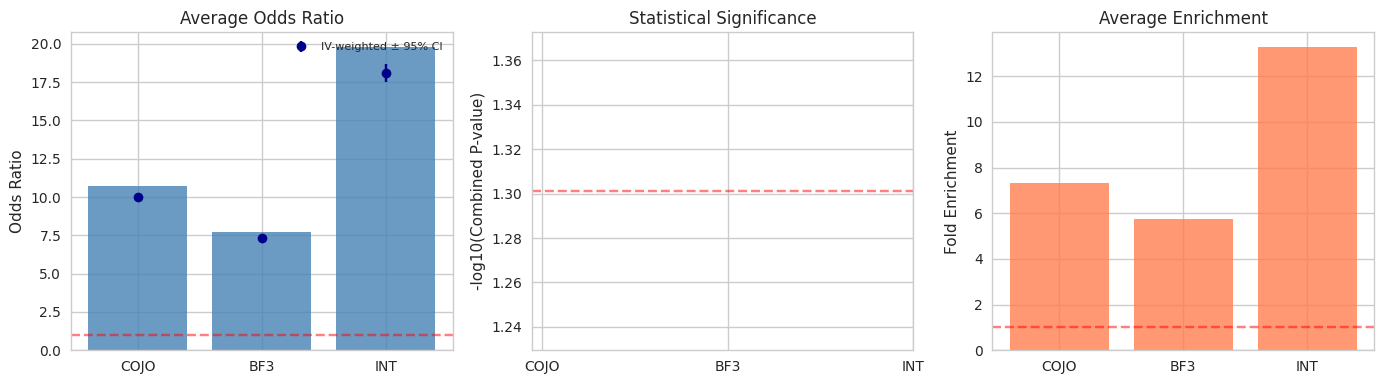


✓ Comparison figure saved


In [17]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

datasets = ['COJO', 'BF3', 'INT']
analyses = [cojo_analysis, bf3_analysis, int_analysis]
x = np.arange(len(datasets))

# Odds Ratio
or_vals = [a['aggregate']['or_geometric_mean'] for a in analyses]
or_ci_l = [a['aggregate']['or_iv_ci_lower'] for a in analyses]
or_ci_u = [a['aggregate']['or_iv_ci_upper'] for a in analyses]

axes[0].bar(x, or_vals, color='steelblue', alpha=0.8)
axes[0].errorbar(x, [a['aggregate']['or_iv_weighted'] for a in analyses],
                 yerr=[np.array([a['aggregate']['or_iv_weighted'] for a in analyses]) - np.array(or_ci_l),
                       np.array(or_ci_u) - np.array([a['aggregate']['or_iv_weighted'] for a in analyses])],
                 fmt='o', color='darkblue', capsize=5, label='IV-weighted ± 95% CI')
axes[0].set_xticks(x)
axes[0].set_xticklabels(datasets)
axes[0].set_ylabel('Odds Ratio')
axes[0].set_title('Average Odds Ratio')
axes[0].axhline(y=1, color='red', linestyle='--', alpha=0.5)
axes[0].legend(loc='upper right', fontsize=8)

# P-value (log scale)
p_vals = [a['aggregate']['p_combined_fisher'] for a in analyses]
axes[1].bar(x, -np.log10(p_vals), color='forestgreen', alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(datasets)
axes[1].set_ylabel('-log10(Combined P-value)')
axes[1].set_title('Statistical Significance')
axes[1].axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.5, label='p=0.05')

# Enrichment
enr_vals = [a['aggregate']['enrichment_geometric_mean'] for a in analyses]
axes[2].bar(x, enr_vals, color='coral', alpha=0.8)
axes[2].set_xticks(x)
axes[2].set_xticklabels(datasets)
axes[2].set_ylabel('Fold Enrichment')
axes[2].set_title('Average Enrichment')
axes[2].axhline(y=1, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('epfinder_aggregate_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comparison figure saved")

## 6. Best Configurations per Dataset

In [18]:
print("\n" + "="*60)
print("BEST CONFIGURATIONS BY ODDS RATIO")
print("="*60)

for name, analysis in [('COJO', cojo_analysis), ('BF3', bf3_analysis), ('INT', int_analysis)]:
    print(f"\n--- {name} Top 5 ---")
    print(analysis['best'].head().to_string(index=False))


BEST CONFIGURATIONS BY ODDS RATIO

--- COJO Top 5 ---
 top_n   cutoff  n_predicted  n_positive_in_predicted  precision  enrichment  odds_ratio      p_value  n_loci_contributing  pct_loci_contributing
     2 0.739827           69                        5   0.072464   29.995375   35.982143 1.833685e-26                   60              11.650485
     3 0.739435           72                        5   0.069444   28.745567   34.365672 2.363680e-25                   61              11.844660
     4 0.739153           73                        5   0.068493   28.351792   33.858543 5.290140e-25                   61              11.844660
     5 0.739055           73                        5   0.068493   28.351792   33.858543 5.290140e-25                   61              11.844660
     1 0.740647           58                        4   0.068966   28.547322   33.340224 2.253882e-19                   58              11.262136

--- BF3 Top 5 ---
 top_n   cutoff  n_predicted  n_positive_in_predic

In [19]:
print("\n" + "="*60)
print("SUMMARY BY TOP-N VALUE")
print("="*60)

for name, analysis in [('COJO', cojo_analysis), ('BF3', bf3_analysis), ('INT', int_analysis)]:
    print(f"\n--- {name} ---")
    print(analysis['per_topn'].to_string(index=False))


SUMMARY BY TOP-N VALUE

--- COJO ---
 top_n  n_cutoffs   or_mean  or_geometric_mean    or_max  or_at_best    p_at_best  enrichment_at_best  best_cutoff  best_n_predicted
     1         48 11.314951          10.595899 33.340224   33.340224 2.253882e-19           28.547322     0.740647                58
     2         48 13.040158          11.916967 35.982143   35.982143 1.833685e-26           29.995375     0.739827                69
     3         48 12.296392          11.177742 34.365672   34.365672 2.363680e-25           28.745567     0.739435                72
     4         48 12.774302          11.475016 33.858543   33.858543 5.290140e-25           28.351792     0.739153                73
     5         48 13.068980          11.565241 33.858543   33.858543 5.290140e-25           28.351792     0.739055                73
     7         48 12.421687          10.708080 31.531311   31.531311 2.181490e-23           26.534370     0.738259                78
    10         48 11.838577    

## 7. Export Results

In [20]:
# Export aggregate statistics to CSV
comparison_df.to_csv('epfinder_aggregate_statistics.csv', index=False)

# Export detailed results
for name, analysis in [('cojo', cojo_analysis), ('bf3', bf3_analysis), ('int', int_analysis)]:
    analysis['results'].to_csv(f'epfinder_{name}_detailed_results.csv', index=False)
    analysis['per_topn'].to_csv(f'epfinder_{name}_per_topn_summary.csv', index=False)

print("✓ All results exported")

✓ All results exported


## Summary

This optimized analysis provides:

1. **Aggregate Odds Ratio** (to evaluate overall effect size):
   - Geometric mean (recommended for ratios)
   - Inverse-variance weighted (most statistically rigorous)
   - With 95% confidence intervals

2. **Combined P-values** (to evaluate overall significance):
   - Fisher's method (chi-square combination)
   - Stouffer's Z-method
   - Weighted Stouffer's (by sample size)

3. **Per top-N summaries** for comparing different configurations

4. **Best configurations** for optimal parameter selection